In [1]:
import sys
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import math
from scipy.spatial.transform import Rotation as R
import ext_model
import copy


In [2]:
### here it is about tests on a 1D model to save time
dtype = torch.float
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
#device = torch.device("cuda:0") # Uncomment this to run on GPU
print(device) 

cpu


In [3]:
# Class to store the date to be used with minibatch
class MyDataset2D(Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, ell, dist, K, error):
        'Initialization'
        #self.list_IDs  = np.arange(len(ell))
        self.ell = ell
        self.cosell = np.cos(self.ell*np.pi/180.)
        self.sinell = np.sin(self.ell*np.pi/180.)
        self.dist = dist # distance in kpc
        self.K = K # total Absorption
        self.error = error # error on absorption

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.ell)

    def __getitem__(self, index): ### Not sure this is how I should do it
        'Generates one sample of data'
        return torch.tensor((self.cosell[index],self.sinell[index],self.dist[index])), torch.tensor((self.K[index],self.error[index]))


In [4]:
dataset = torch.load('fiducial_model2D.pt', map_location=device)

In [37]:
filebase = "../test_models/fiducial_model2D_mean"
xmax = 5.4998
hidden_size = 288

In [7]:
xmin=0.
xmax=0.
for i in range(dataset.__len__()):
    if dataset.dist[i].item()> xmax:
        xmax = dataset.dist[i].item()
        
for i in range(dataset.__len__()):
    dataset.dist[i]= 2.*dataset.dist[i].item()/(xmax-xmin)-1.


In [8]:
# defines the integration neural network model to be used : here a simple dense model with one 
# input layer of size 3, one hidden layer fully connected  
# and one output layer of size 1.
# Using a sigmoid activation
class Ext2D(nn.Module):
    
    def __init__(self,hidden_size):
        super(Ext2D,self).__init__()
        self.hidden_size = hidden_size
        self.lin1 = nn.Linear(3, hidden_size, bias=True)
        self.lin2 = nn.Linear(hidden_size, 1, bias=True)
        self.Sigmoid = nn.Sigmoid()
        
    def forward(self,x):
        out = self.lin1(x)
        out = self.Sigmoid(out)
        out = self.lin2(out)
        return out

class Ext2D_dropout(nn.Module):
# Warning, with dropout integration does not match the network, to use only for density error estimation
    def __init__(self,hidden_size,proba=0.25):
        super(Ext2D,self).__init__()
        self.hidden_size = hidden_size
        self.lin1 = nn.Linear(3, hidden_size, bias=True)
        self.Sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(proba)
        
    def forward(self,x):
        out = self.lin1(x)
        out = self.dropout(out)
        out = self.Sigmoid(out)
        out = self.lin2(out)
        return out


In [10]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.1)

def create_net_integ(hidden_size,lr=1e-2):
    network = Ext2D(hidden_size)
    return network, optim.Adam(network.parameters(), lr=lr)
#    return network, optim.SGD(network.parameters(), lr=lr)

# Create network for total extinction
network, opti = create_net_integ(hidden_size,lr=1e-3)
network.apply(init_weights)
network.to(device)

Ext2D(
  (lin1): Linear(in_features=3, out_features=288, bias=True)
  (lin2): Linear(in_features=288, out_features=1, bias=True)
  (Sigmoid): Sigmoid()
)

In [23]:
def integral(x,net,xmin=0.,debug=0):
    # Equation 15b of Lloyd et al 2020 -> Phi_j for each neuron
    # Li_1(x) = -ln(1-x) for x \in C
    batch_size = x.size()[0]
    n = x.size()[1] #number of coordinates the last one is the distance
    xmin = x*0. + xmin

    a = -torch.log(1.+torch.exp(-1.*(net.lin1.bias.unsqueeze(1).expand(net.hidden_size,batch_size)
                                    +torch.matmul(net.lin1.weight[:,0:n-1],torch.transpose(x[:,0:n-1],0,1)))
                               - torch.matmul(net.lin1.weight[:,n-1].unsqueeze(1),torch.transpose(xmin[:,n-1].unsqueeze(1),0,1)) ) )
    b = torch.log(1.+torch.exp(-1.*(net.lin1.bias.unsqueeze(1).expand(net.hidden_size,batch_size) 
                                    +torch.matmul(net.lin1.weight[:,0:n-1],torch.transpose(x[:,0:n-1],0,1)))
                               - torch.matmul(net.lin1.weight[:,n-1].unsqueeze(1),torch.transpose(x[:,n-1].unsqueeze(1),0,1)) ) )

    phi_j = a + b
   
    # Equation 15a of Lloyd et al 2020 : alpha_1=0, beta_1=x
    # sum over al neurons of the hidden layer
    aa = net.lin2.bias * (x[:,n-1] - xmin[:,n-1])
        
    bb = torch.matmul(net.lin2.weight[0,:] , (torch.transpose((x[:,n-1]-xmin[:,n-1]).unsqueeze(1),0,1).expand(net.hidden_size,batch_size) 
        + torch.transpose(torch.div(torch.transpose(phi_j,0,1),net.lin1.weight[:,n-1]),0,1) ) ) 
    
    res = aa + bb

    return res
 

In [41]:
network=Ext2D(hidden_size)

# load checkpoint file
checkpoint = torch.load(filebase+"_e340000.pt",map_location='cpu')

# update networks to checkpoint state
network.load_state_dict(checkpoint['integ_state_dict'])

# update optimizers state
opti.load_state_dict(checkpoint['opti_state_dict'])

# update epoch and loss function
#epoch = checkpoint['epoch']
#loss = checkpoint['loss']

network.to(device)    
network.eval()

RuntimeError: ../test_models/fiducial_model2D_mean_e340000.pt is a zip archive (did you mean to use torch.jit.load()?)

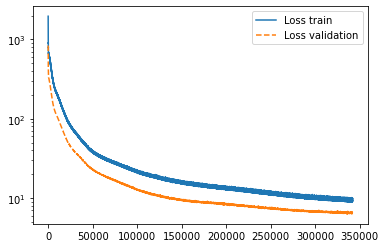

In [39]:

loss = np.loadtxt(filebase+".loss")
val = np.loadtxt(filebase+".val")

plt.figure()
plt.plot(loss[:,0],loss[:,1],label="Loss train")
plt.plot(val[:,0],val[:,1],'--',label="Loss validation")

plt.yscale('log')
plt.legend(loc="upper right")
plt.show()


In [18]:
class extmy_model:
    def __init__(self,N):
        self.rho = np.random.rand(N)*0.1 # core density
        self.x0 = np.random.rand(N)*8.-4. # cartesian location of cloud [-4,4] kpc
        self.y0 = np.random.rand(N)*8.-4. # cartesian location of cloud [-4,4] kpc
        self.z0 = np.random.rand(N)-0.5   # cartesian location od cloud [-0.5,0.5] kpc
        self.s1 = 0.05+np.random.rand(N)*0.05 # size along axis kpc
        self.s2 = 0.05+np.random.rand(N)*0.05
        self.s3 = 0.05+np.random.rand(N)*0.05
        self.a1 = np.random.rand(N)*60.-30. # orientation [-30,30] deg
        self.a2 = np.random.rand(N)*90.-45. # orientation [-45,45] deg

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.rho)

 

In [19]:
fmodel = "ext_model2D.pickle"
# Loads model
with open(fmodel,"rb") as file:
    myext_model = pickle.load(file)
    file.close()

In [21]:
load_dens = 1
X,Y = np.mgrid[-5:5.1:0.1, -5:5.1:0.1]
if load_dens == 0:
    dens_true = X*0.
    ext_true = X*0.
    ell = X *0.
    R = X * 0.
    for i in range(len(X[:,1])):
        for j in range(len(X[1,:])):
            ell[i,j], R[i,j] = ext_model.xy_ld(X[i,j],Y[i,j])
            dens_true[i,j] = ext_model.ext_model(X[i,j],Y[i,j],0.,myext_model)
            ext_true[i,j] = ext_model.integ_d(ext_model.ext_model,ell[i,j],0.,R[i,j],myext_model)
    np.savez("ext_2D_grid.npz",ell=ell,R=R,dens_true=dens_true,ext_true=ext_true)
else:
    npzfile = np.load("ext_2D_grid.npz")
    ell = npzfile['ell']
    R = npzfile['R']
    dens_true = npzfile['dens_true']
    ext_true = npzfile['ext_true']
    

In [24]:
dens_network= X*0.
ext_network = X*0.
R = np.sqrt(X*X+Y*Y)
#for i in range(len(X)):
cosell=X/R
sinell=Y/R
#data = torch.tensor([cosell,sinell,2.*R/xmax-1.]).float() # data in [-1,1]
#print(data.size())
#res = integral(torch.transpose(data.to(device),0,1),network,xmin=-1.)
for i in range(len(X[0,:])):
    for j in range(len(X[:,0])):
        data=torch.Tensor([cosell[i,j],sinell[i,j],2.*R[i,j]/xmax-1.]).float()
        dens_network[i,j] = network(data.to(device))
        data =data.unsqueeze(1)
        ext_network[i,j] = integral(torch.transpose(data.to(device),0,1),network,xmin=-1.)


/home/arnaud.siebert/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/home/arnaud.siebert/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


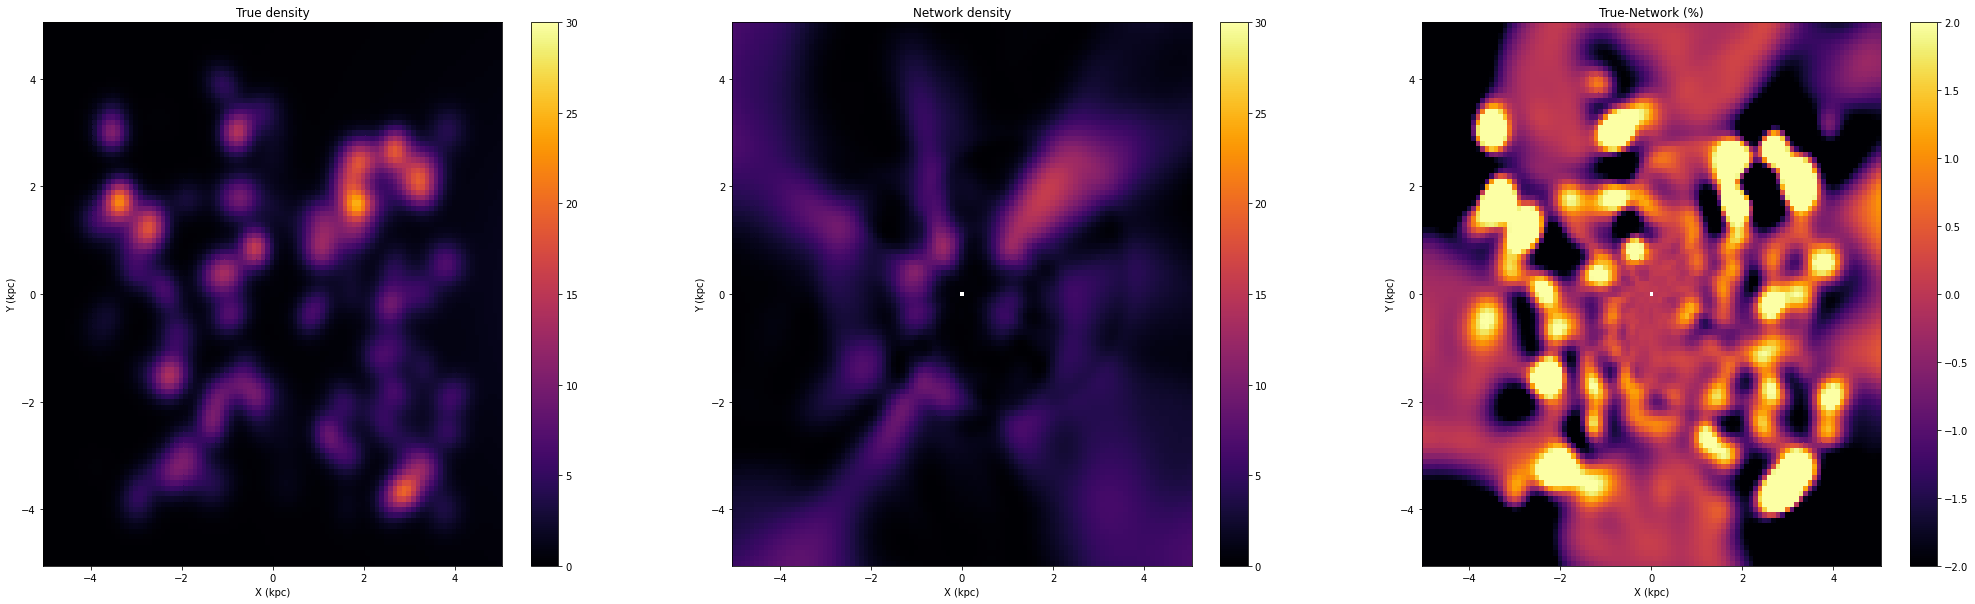

In [25]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(35,10))
cs = ax1.set_title('True density')
cs1 = ax1.pcolormesh(X, Y, dens_true, shading='auto', vmin=0., vmax=30,cmap=plt.cm.inferno)
cs = ax2.set_title('Network density')
cs2 = ax2.pcolormesh(X, Y, dens_network*2./xmax, shading='auto', vmin=0., vmax=30, cmap=plt.cm.inferno)
cs = ax3.set_title('True-Network (%)')
cs3 = ax3.pcolormesh(X, Y, (dens_true-dens_network*2./xmax), vmin=-2,vmax=2, shading='auto', cmap=plt.cm.inferno)
ax1.set_xlabel('X (kpc)')
ax1.set_ylabel('Y (kpc)')
ax2.set_xlabel('X (kpc)')
ax2.set_ylabel('Y (kpc)')
ax3.set_xlabel('X (kpc)')
ax3.set_ylabel('Y (kpc)')
fig.colorbar(cs1,ax=ax1)
fig.colorbar(cs2,ax=ax2)
fig.colorbar(cs3,ax=ax3)
plt.savefig('ext_2D_dens_mean_e250000.png')
plt.show()


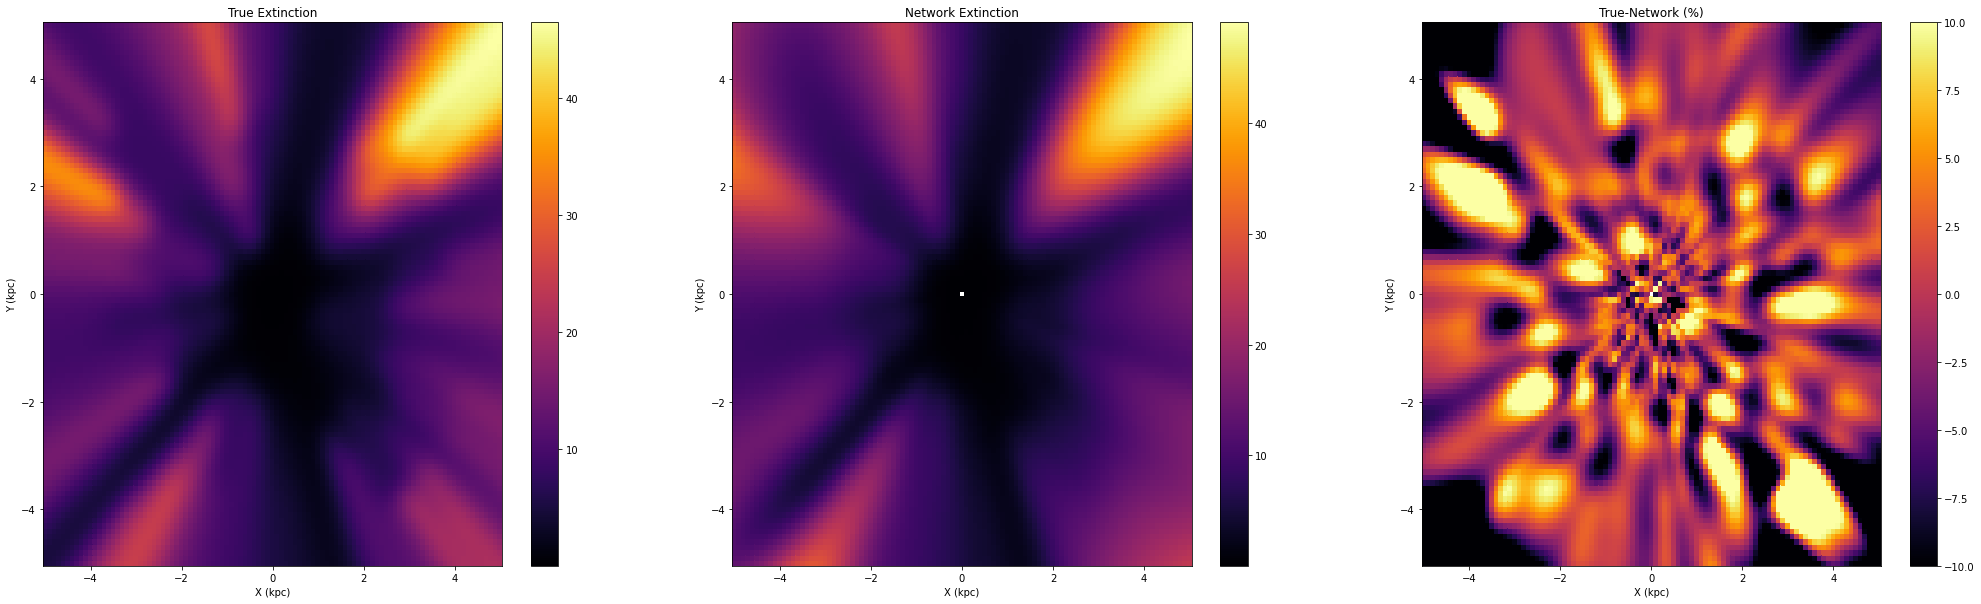

In [26]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(35,10))
cs = ax1.set_title('True Extinction')
cs1 = ax1.pcolormesh(X, Y, ext_true, shading='auto', cmap=plt.cm.inferno)
cs = ax2.set_title('Network Extinction')
cs2 = ax2.pcolormesh(X, Y, ext_network, shading='auto', cmap=plt.cm.inferno)
cs = ax3.set_title('True-Network (%)')
cs3 = ax3.pcolormesh(X, Y, (ext_true-ext_network)/ext_true*100., vmin=-10,vmax=10, shading='auto', cmap=plt.cm.inferno)
ax1.set_xlabel('X (kpc)')
ax1.set_ylabel('Y (kpc)')
ax2.set_xlabel('X (kpc)')
ax2.set_ylabel('Y (kpc)')
ax3.set_xlabel('X (kpc)')
ax3.set_ylabel('Y (kpc)')
fig.colorbar(cs1,ax=ax1)
fig.colorbar(cs2,ax=ax2)
fig.colorbar(cs3,ax=ax3)
plt.savefig('ext_2D_ext_mean_e25000.png')
plt.show()


In [28]:
load_los=0

if load_los==0:
    ells=np.array([0.,45.,90.,135.,180.,225.,270.,315.])
    cosell=np.cos(ells*np.pi/180.)
    sinell=np.sin(ells*np.pi/180.)
    dist=np.linspace(0.,7.,num=71)

    los_dens_network=np.zeros((8,71))
    los_ext_network=np.zeros((8,71))
    los_dens_true=np.zeros((8,71))
    los_ext_true=np.zeros((8,71))

    for i in range(len(ells)):
        for j in range(len(dist)):
            data=torch.Tensor([cosell[i],sinell[i],2.*dist[j]/xmax-1.]).float()
            los_dens_network[i,j] = network(data.to(device))
            data =data.unsqueeze(1)
            los_ext_network[i,j] = integral(torch.transpose(data.to(device),0,1),network,xmin=-1.)

            X = dist[j]*cosell[i]
            Y = dist[j]*sinell[i]
            los_dens_true[i,j] = ext_model.ext_model(X,Y,0.,myext_model)
            los_ext_true[i,j] = ext_model.integ_d(ext_model.ext_model,ells[i],0.,dist[j],myext_model)
    np.savez("ext_2D_mean_e250000.npz",ells=ells,dist=dist,los_dens_true=los_dens_true,los_ext_true=los_ext_true,los_dens_network=los_dens_network,los_ext_network=los_ext_network)
else :
    npzfile = np.load("ext_2D_mean_e250000.npz")
    ells = npzfile['ells']
    dist = npzfile['dist']
    los_dens_true = npzfile['los_dens_true']
    los_ext_true = npzfile['los_ext_true']
    los_dens_network = npzfile['los_dens_network']
    los_ext_network = npzfile['los_ext_network']
 

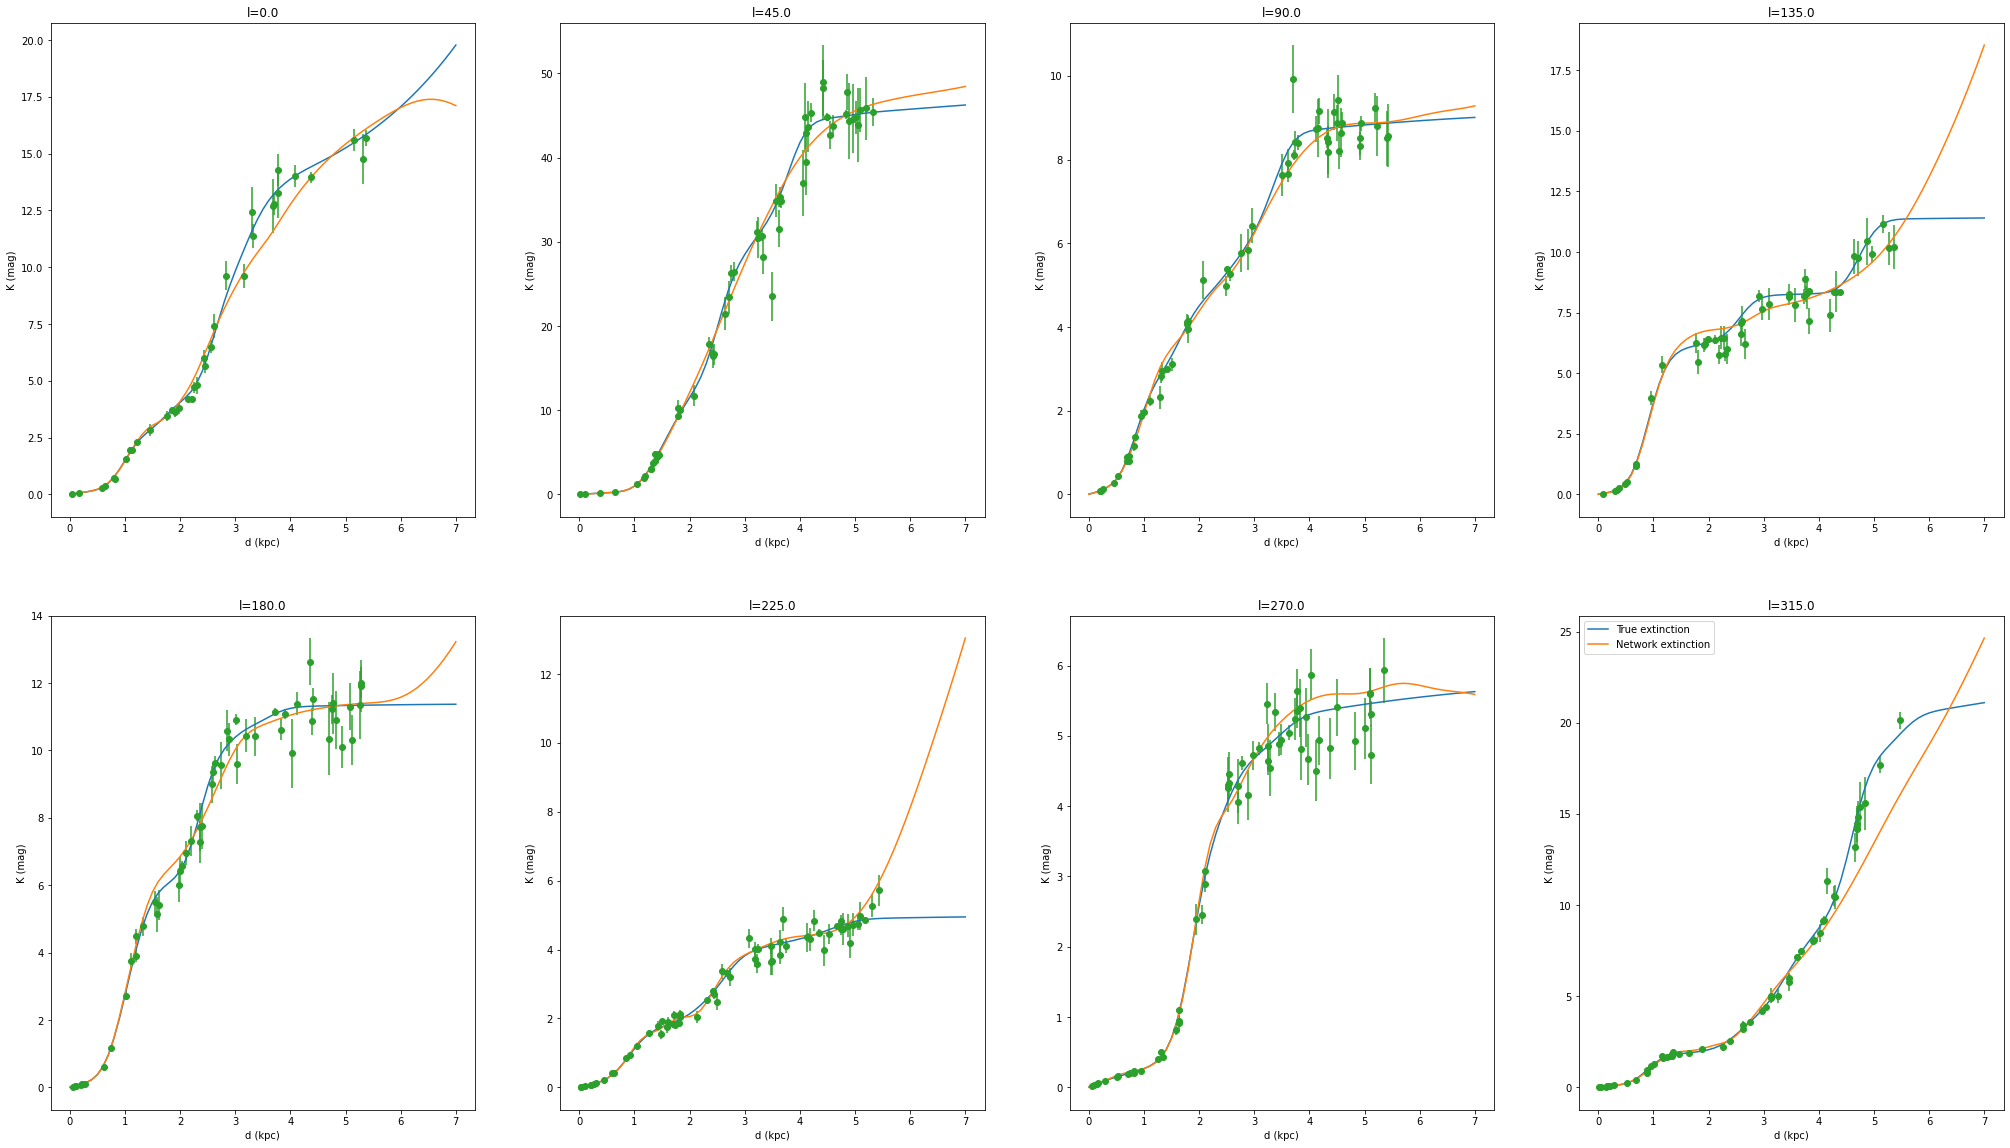

In [33]:
# Plot the extinction generalisation and estimates reconstruction errors for the LOSs

fig, ((ax1, ax2, ax3, ax4),(ax5,ax6,ax7,ax8)) = plt.subplots(2, 4, figsize=(35,20))
delta=0.5
ttl = 'l='+str(ells[0])
ax1.set_title(ttl)
ax1.plot(dist,los_ext_true[0,:],label='True extinction')
ax1.plot(dist,los_ext_network[0,:],label='Network extinction')
xdata=[]
ydata=[]
errdata=[]
for i in range(dataset.__len__()):
    if dataset.ell[i].item()> ells[0]-delta and dataset.ell[i].item()<= ells[0]+delta:
        #print(i)
        xdata.append( (1.+dataset.dist[i].item())*xmax/2. )
        ydata.append( dataset.K[i] )
        errdata.append( dataset.error[i].item() )
xdata=np.array(xdata)
ydata=np.array(ydata)
recerr1=dist*0.
for i in range(len(dist)):
    idx = np.where(np.abs(dist[i]-xdata)<0.2)
    if len(idx[0])>0:
        recerr1[i]=np.var(los_ext_network[0,i]-ydata[idx])
    else:
        recerr1[i]=los_ext_network[0,i]*los_ext_network[0,i]
ax1.errorbar(xdata,ydata,yerr=errdata,fmt='o')
ax1.set_xlabel('d (kpc)')
ax1.set_ylabel('K (mag)')

ttl = 'l='+str(ells[1])
ax2.set_title(ttl)
ax2.plot(dist,los_ext_true[1,:],label='True extinction')
ax2.plot(dist,los_ext_network[1,:],label='Network extinction')
xdata=[]
ydata=[]
errdata=[]
for i in range(dataset.__len__()):
    if dataset.ell[i].item()> ells[1]-delta and dataset.ell[i].item()<= ells[1]+delta:
        xdata.append((1.+dataset.dist[i].item())*xmax/2.)
        ydata.append(dataset.K[i])
        errdata.append(dataset.error[i].item())
xdata=np.array(xdata)
ydata=np.array(ydata)
recerr2=dist*0.
for i in range(len(dist)):
    idx = np.where(abs(dist[i]-xdata)<0.2)
    if len(idx[0])>0:
        recerr2[i]=np.var(los_ext_network[1,i]-ydata[idx])
    else:
        recerr2[i]=los_ext_network[1,i]*los_ext_network[1,i]
ax2.errorbar(xdata,ydata,yerr=errdata,fmt='o')
ax2.set_xlabel('d (kpc)')
ax2.set_ylabel('K (mag)')

ttl = 'l='+str(ells[2])
ax3.set_title(ttl)
ax3.plot(dist,los_ext_true[2,:],label='True extinction')
ax3.plot(dist,los_ext_network[2,:],label='Network extinction')
xdata=[]
ydata=[]
errdata=[]
for i in range(dataset.__len__()):
    if dataset.ell[i].item()> ells[2]-delta and dataset.ell[i].item()<= ells[2]+delta:
        xdata.append((1.+dataset.dist[i].item())*xmax/2.)
        ydata.append(dataset.K[i])
        errdata.append(dataset.error[i].item())
xdata=np.array(xdata)
ydata=np.array(ydata)
recerr3=dist*0.
for i in range(len(dist)):
    idx = np.where(abs(dist[i]-xdata)<0.2)
    if len(idx[0])>0:
        recerr3[i]=np.var(los_ext_network[2,i]-ydata[idx])
    else:
        recerr3[i]=los_ext_network[2,i]*los_ext_network[2,i]
ax3.errorbar(xdata,ydata,yerr=errdata,fmt='o')
ax3.set_xlabel('d (kpc)')
ax3.set_ylabel('K (mag)')

ttl = 'l='+str(ells[3])
ax4.set_title(ttl)
ax4.plot(dist,los_ext_true[3,:],label='True extinction')
ax4.plot(dist,los_ext_network[3,:],label='Network extinction')
xdata=[]
ydata=[]
errdata=[]
for i in range(dataset.__len__()):
    if dataset.ell[i].item()> ells[3]-delta and dataset.ell[i].item()<= ells[3]+delta:
        xdata.append((1.+dataset.dist[i].item())*xmax/2.)
        ydata.append(dataset.K[i])
        errdata.append(dataset.error[i].item())
xdata=np.array(xdata)
ydata=np.array(ydata)
recerr4=dist*0.
for i in range(len(dist)):
    idx = np.where(abs(dist[i]-xdata)<0.2)
    if len(idx[0])>0:
        recerr4[i]=np.var(los_ext_network[3,i]-ydata[idx])
    else:
        recerr4[i]=los_ext_network[3,i]*los_ext_network[3,i]
ax4.errorbar(xdata,ydata,yerr=errdata,fmt='o')
ax4.set_xlabel('d (kpc)')
ax4.set_ylabel('K (mag)')

ttl = 'l='+str(ells[4])
ax5.set_title(ttl)
ax5.plot(dist,los_ext_true[4,:],label='True extinction')
ax5.plot(dist,los_ext_network[4,:],label='Network extinction')
xdata=[]
ydata=[]
errdata=[]
for i in range(dataset.__len__()):
    if dataset.ell[i].item()> ells[4]-delta and dataset.ell[i].item()<= ells[4]+delta:
        xdata.append((1.+dataset.dist[i].item())*xmax/2.)
        ydata.append(dataset.K[i])
        errdata.append(dataset.error[i].item())
xdata=np.array(xdata)
ydata=np.array(ydata)
recerr5=dist*0.
for i in range(len(dist)):
    idx = np.where(abs(dist[i]-xdata)<0.2)
    if len(idx[0])>0:
        recerr5[i]=np.var(los_ext_network[4,i]-ydata[idx])
    else:
        recerr5[i]=los_ext_network[4,i]*los_ext_network[4,i]
ax5.errorbar(xdata,ydata,yerr=errdata,fmt='o')
ax5.set_xlabel('d (kpc)')
ax5.set_ylabel('K (mag)')

ttl = 'l='+str(ells[5])
ax6.set_title(ttl)
ax6.plot(dist,los_ext_true[5,:],label='True extinction')
ax6.plot(dist,los_ext_network[5,:],label='Network extinction')
xdata=[]
ydata=[]
errdata=[]
for i in range(dataset.__len__()):
    if dataset.ell[i].item()> ells[5]-delta and dataset.ell[i].item()<= ells[5]+delta:
        xdata.append((1.+dataset.dist[i].item())*xmax/2.)
        ydata.append(dataset.K[i])
        errdata.append(dataset.error[i].item())
xdata=np.array(xdata)
ydata=np.array(ydata)
recerr6=dist*0.
for i in range(len(dist)):
    idx = np.where(abs(dist[i]-xdata)<0.2)
    if len(idx[0])>0:
        recerr6[i]=np.var(los_ext_network[5,i]-ydata[idx])
    else:
        recerr6[i]=los_ext_network[5,i]*los_ext_network[5,i]
ax6.errorbar(xdata,ydata,yerr=errdata,fmt='o')
ax6.set_xlabel('d (kpc)')
ax6.set_ylabel('K (mag)')

ttl = 'l='+str(ells[6])
ax7.set_title(ttl)
ax7.plot(dist,los_ext_true[6,:],label='True extinction')
ax7.plot(dist,los_ext_network[6,:],label='Network extinction')
xdata=[]
ydata=[]
errdata=[]
for i in range(dataset.__len__()):
    if dataset.ell[i].item()> ells[6]-delta and dataset.ell[i].item()<= ells[6]+delta:
        xdata.append((1.+dataset.dist[i].item())*xmax/2.)
        ydata.append(dataset.K[i])
        errdata.append(dataset.error[i].item())
xdata=np.array(xdata)
ydata=np.array(ydata)
recerr7=dist*0.
for i in range(len(dist)):
    idx = np.where(abs(dist[i]-xdata)<0.2)
    if len(idx[0])>0:
        recerr7[i]=np.var(los_ext_network[6,i]-ydata[idx])
    else:
        recerr7[i]=los_ext_network[6,i]*los_ext_network[6,i]
ax7.errorbar(xdata,ydata,yerr=errdata,fmt='o')
ax7.set_xlabel('d (kpc)')
ax7.set_ylabel('K (mag)')

ttl = 'l='+str(ells[7])
ax8.set_title(ttl)
ax8.plot(dist,los_ext_true[7,:],label='True extinction')
ax8.plot(dist,los_ext_network[7,:],label='Network extinction')
xdata=[]
ydata=[]
errdata=[]
for i in range(dataset.__len__()):
    if dataset.ell[i].item()> ells[7]-delta and dataset.ell[i].item()<= ells[7]+delta:
        xdata.append((1.+dataset.dist[i].item())*xmax/2.)
        ydata.append(dataset.K[i])
        errdata.append(dataset.error[i].item())
xdata=np.array(xdata)
ydata=np.array(ydata)
recerr8=dist*0.
for i in range(len(dist)):
    idx = np.where(abs(dist[i]-xdata)<0.2)
    if len(idx[0])>0:
        recerr8[i]=np.var(los_ext_network[7,i]-ydata[idx])
    else:
        recerr8[i]=los_ext_network[7,i]*los_ext_network[7,i]
ax8.errorbar(xdata,ydata,yerr=errdata,fmt='o')
ax8.set_xlabel('d (kpc)')
ax8.set_ylabel('K (mag)')

plt.legend()
plt.savefig('ext_2D_losext_248.png')
plt.show()

In [34]:
network_dropout = copy.deepcopy(network)
network_dropout.lin2 = nn.Sequential(
    nn.Dropout(0.01),
#     nn.Linear(network.lin2.in_features, 1)
    network.lin2
)

#for name, param in network.named_parameters():
#    if param.requires_grad:
#        print(name, param.data)

# Use MC dropout to estimate error on density
los_dens_network_MCdropout=np.zeros((8,71,100))
network_dropout.train()
print(ells)
print(dist)
cosell=np.cos(ells*np.pi/180.)
sinell=np.sin(ells*np.pi/180.)
for i in range(len(ells)):
    for j in range(len(dist)):
        data=torch.Tensor([cosell[i],sinell[i],2.*dist[j]/xmax-1.]).float()
        for k in range(99):
            los_dens_network_MCdropout[i,j,k] = network_dropout(data.to(device))
        los_dens_network_MCdropout[i,j,99] = network(data.to(device))

minlev = np.percentile(los_dens_network_MCdropout,15.9,axis=2)*2./xmax
maxlev = np.percentile(los_dens_network_MCdropout,84.1,axis=2)*2./xmax


[  0.  45.  90. 135. 180. 225. 270. 315.]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5
 3.6 3.7 3.8 3.9 4.  4.1 4.2 4.3 4.4 4.5 4.6 4.7 4.8 4.9 5.  5.1 5.2 5.3
 5.4 5.5 5.6 5.7 5.8 5.9 6.  6.1 6.2 6.3 6.4 6.5 6.6 6.7 6.8 6.9 7. ]


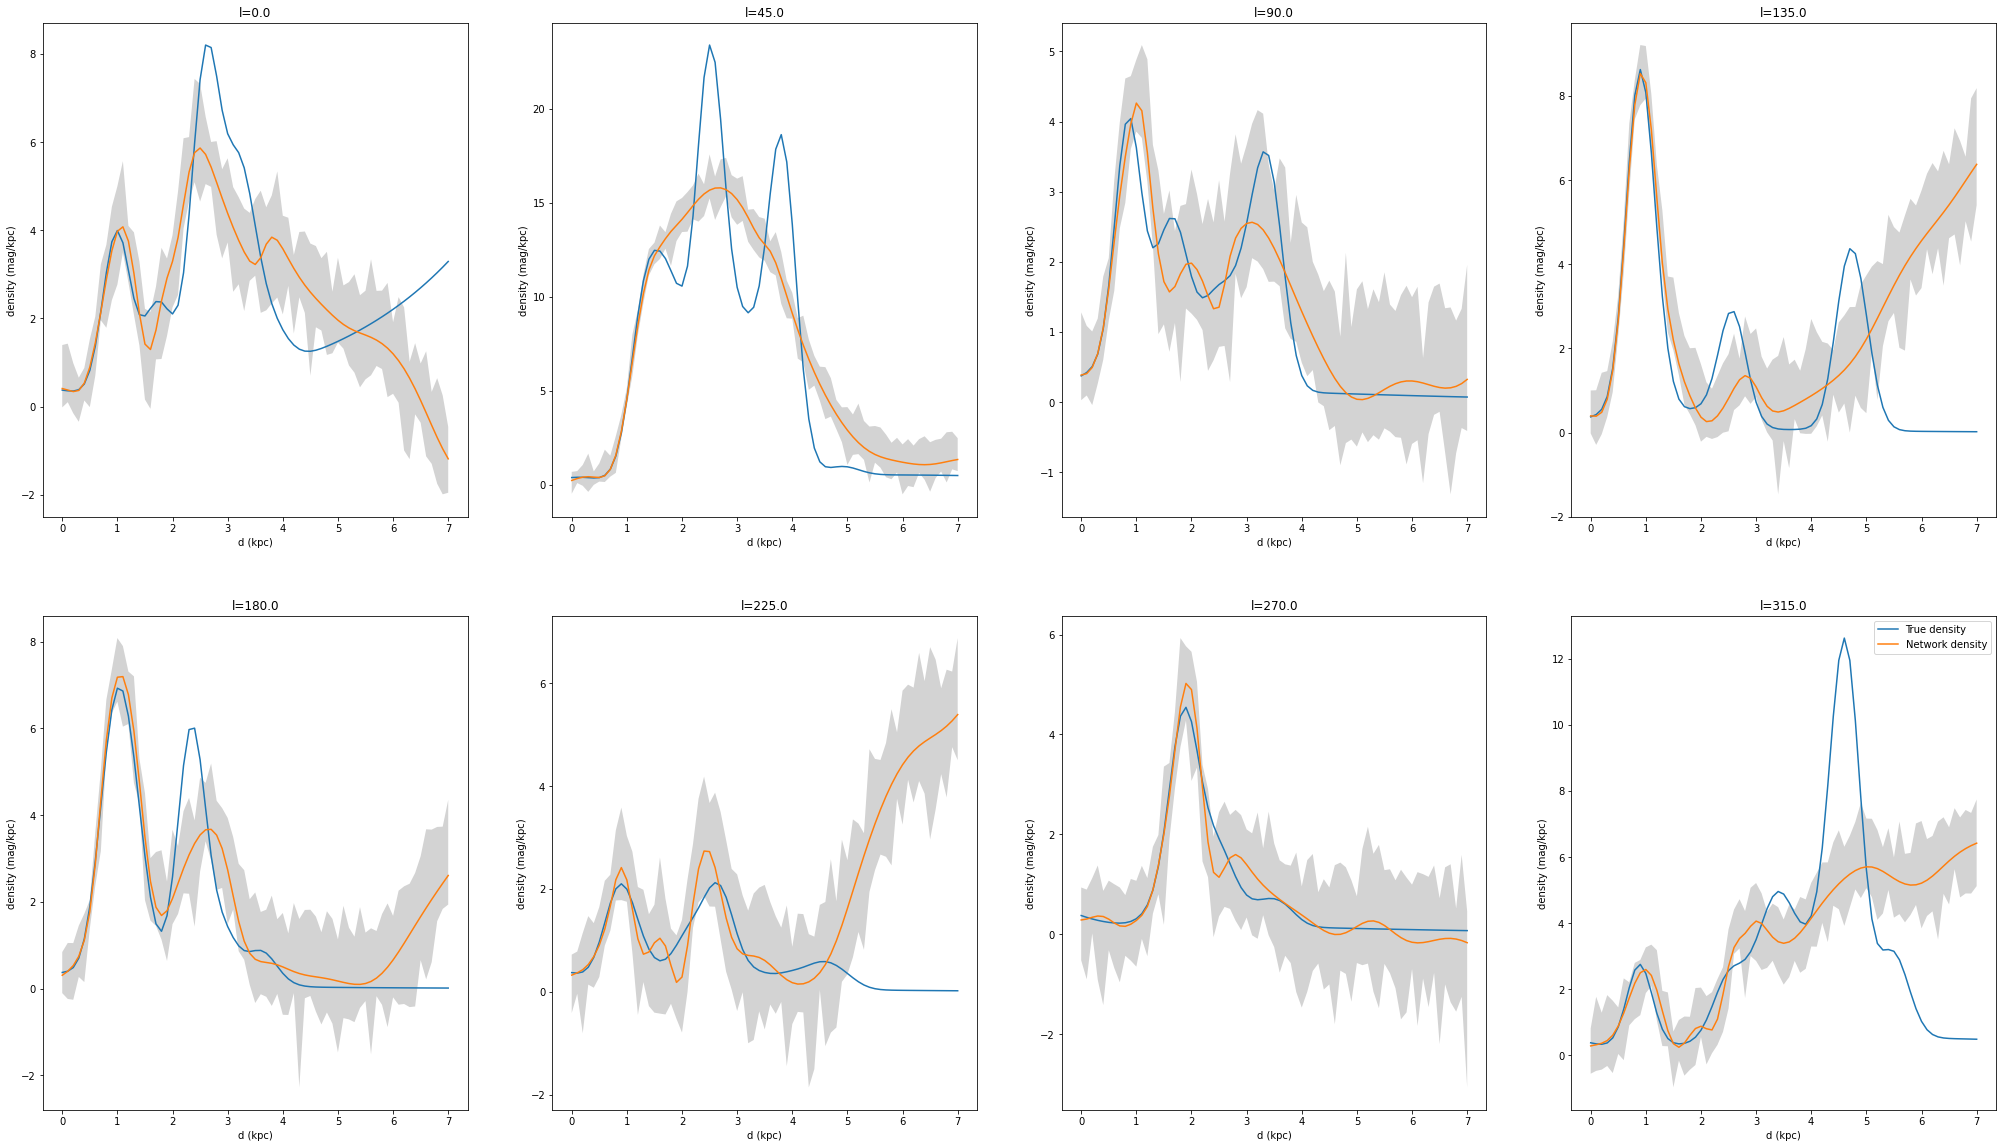

In [35]:
fig, ((ax1, ax2, ax3, ax4),(ax5,ax6,ax7,ax8)) = plt.subplots(2, 4, figsize=(35,20))
delta=0.5
ttl = 'l='+str(ells[0])
ax1.set_title(ttl)
#ax1.fill_between(dist, los_dens_network[0,:]*2./xmax*(1.-np.sqrt(recerr1)/los_ext_network[0,:]), 
#    los_dens_network[0,:]*2./xmax*(1.+np.sqrt(recerr1)/los_ext_network[0,:]), facecolor='lightgrey',interpolate=True)
ax1.fill_between(dist,minlev[0,:],maxlev[0,:], facecolor='lightgrey',interpolate=True)
ax1.plot(dist,los_dens_true[0,:],label='True density')
ax1.plot(dist,los_dens_network[0,:]*2./xmax,label='Network density')
ax1.set_xlabel('d (kpc)')
ax1.set_ylabel('density (mag/kpc)')

ttl = 'l='+str(ells[1])
ax2.set_title(ttl)
#ax2.fill_between(dist, los_dens_network[1,:]*2./xmax*(1.-np.sqrt(recerr2)/los_ext_network[1,:]), 
#    los_dens_network[1,:]*2./xmax*(1.+np.sqrt(recerr2)/los_ext_network[1,:]), facecolor='lightgrey',interpolate=True)
ax2.fill_between(dist,minlev[1,:],maxlev[1,:], facecolor='lightgrey',interpolate=True)
ax2.plot(dist,los_dens_true[1,:],label='True density')
ax2.plot(dist,los_dens_network[1,:]*2./xmax,label='Network density')
ax2.set_xlabel('d (kpc)')
ax2.set_ylabel('density (mag/kpc)')

ttl = 'l='+str(ells[2])
ax3.set_title(ttl)
#ax3.fill_between(dist, los_dens_network[2,:]*2./xmax*(1.-np.sqrt(recerr3)/los_ext_network[2,:]), 
#    los_dens_network[2,:]*2./xmax*(1.+np.sqrt(recerr3)/los_ext_network[2,:]), facecolor='lightgrey',interpolate=True)
ax3.fill_between(dist,minlev[2,:],maxlev[2,:], facecolor='lightgrey',interpolate=True)
ax3.plot(dist,los_dens_true[2,:],label='True density')
ax3.plot(dist,los_dens_network[2,:]*2./xmax,label='Network density')
ax3.set_xlabel('d (kpc)')
ax3.set_ylabel('density (mag/kpc)')

ttl = 'l='+str(ells[3])
ax4.set_title(ttl)
#ax4.fill_between(dist, los_dens_network[3,:]*2./xmax*(1.-np.sqrt(recerr4)/los_ext_network[3,:]), 
#    los_dens_network[3,:]*2./xmax*(1.+np.sqrt(recerr4)/los_ext_network[3,:]), facecolor='lightgrey',interpolate=True)
ax4.fill_between(dist,minlev[3,:],maxlev[3,:], facecolor='lightgrey',interpolate=True)
ax4.plot(dist,los_dens_true[3,:],label='True density')
ax4.plot(dist,los_dens_network[3,:]*2./xmax,label='Network density')
ax4.set_xlabel('d (kpc)')
ax4.set_ylabel('density (mag/kpc)')

ttl = 'l='+str(ells[4])
ax5.set_title(ttl)
#ax5.fill_between(dist, los_dens_network[4,:]*2./xmax*(1.-np.sqrt(recerr5)/los_ext_network[4,:]), 
#    los_dens_network[4,:]*2./xmax*(1.+np.sqrt(recerr5)/los_ext_network[4,:]), facecolor='lightgrey',interpolate=True)
ax5.fill_between(dist,minlev[4,:],maxlev[4,:], facecolor='lightgrey',interpolate=True)
ax5.plot(dist,los_dens_true[4,:],label='True density')
ax5.plot(dist,los_dens_network[4,:]*2./xmax,label='Network density')
ax5.set_xlabel('d (kpc)')
ax5.set_ylabel('density (mag/kpc)')

ttl = 'l='+str(ells[5])
ax6.set_title(ttl)
#ax6.fill_between(dist, los_dens_network[5,:]*2./xmax*(1.-np.sqrt(recerr6)/los_ext_network[5,:]), 
#    los_dens_network[5,:]*2./xmax*(1.+np.sqrt(recerr6)/los_ext_network[5,:]), facecolor='lightgrey',interpolate=True)
ax6.fill_between(dist,minlev[5,:],maxlev[5,:], facecolor='lightgrey',interpolate=True)
ax6.plot(dist,los_dens_true[5,:],label='True density')
ax6.plot(dist,los_dens_network[5,:]*2./xmax,label='Network density')
ax6.set_xlabel('d (kpc)')
ax6.set_ylabel('density (mag/kpc)')

ttl = 'l='+str(ells[6])
ax7.set_title(ttl)
#ax7.fill_between(dist, los_dens_network[6,:]*2./xmax*(1.-np.sqrt(recerr7)/los_ext_network[6,:]), 
#    los_dens_network[6,:]*2./xmax*(1.+np.sqrt(recerr7)/los_ext_network[6,:]), facecolor='lightgrey',interpolate=True)
ax7.fill_between(dist,minlev[6,:],maxlev[6,:], facecolor='lightgrey',interpolate=True)
ax7.plot(dist,los_dens_true[6,:],label='True density')
ax7.plot(dist,los_dens_network[6,:]*2./xmax,label='Network density')
ax7.set_xlabel('d (kpc)')
ax7.set_ylabel('density (mag/kpc)')

ttl = 'l='+str(ells[7])
ax8.set_title(ttl)
#ax8.fill_between(dist, los_dens_network[7,:]*2./xmax*(1.-np.sqrt(recerr8)/los_ext_network[7,:]), 
#    los_dens_network[7,:]*2./xmax*(1.+np.sqrt(recerr8)/los_ext_network[7,:]), facecolor='lightgrey',interpolate=True)
ax8.fill_between(dist,minlev[7,:],maxlev[7,:], facecolor='lightgrey',interpolate=True)
ax8.plot(dist,los_dens_true[7,:],label='True density')
ax8.plot(dist,los_dens_network[7,:]*2./xmax,label='Network density')
ax8.set_xlabel('d (kpc)')
ax8.set_ylabel('density (mag/kpc)')

plt.legend()
plt.savefig('los_2D_248neurons.png')
plt.show()